# Prosty model trójwarstwowej sieci
### Przygotowania

In [97]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from utils import get_4_classes_from_target, load_clean_data, get_2_classes_from_target

In [98]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [99]:
class CleaningEfficiencyModel(nn.Module):
    def __init__(self, num_feature, num_class):
        super().__init__()
        
        #self.layer_1 = nn.Linear(num_feature, 512)
        #self.layer_2 = nn.Linear(512, 128)
        #self.layer_3 = nn.Linear(128, 64)
        #self.layer_out = nn.Linear(64, num_class) 
        
        #self.relu = nn.ReLU()
        #self.dropout = nn.Dropout(p=0.2)
        #self.batchnorm1 = nn.BatchNorm1d(512)
        #self.batchnorm2 = nn.BatchNorm1d(128)
        #self.batchnorm3 = nn.BatchNorm1d(64)
        
        self.layer_1 = nn.Linear(num_feature, 10)
        self.layer_out = nn.Linear(10, num_class) 
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=0.2)
        self.sigmoid = nn.Sigmoid()
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
       
    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.sigmoid(self.layer_out(x))
        # x = self.layer_1(x)
        # x = self.relu(x)
        
        # x = self.layer_out(x)
        # x = self.softmax(x)
        
        return x

## Przypadek pierwszy  
#### Skala oceny efektywności oczyszczania RE:
- mniej niż 20% jako **0**
- 20%-50% jako **1**
- 50%-80% jako **2**
- więcej niż 80% jako **3**

In [100]:
dataset_cleaned = load_clean_data()

# wyodrębnienie "target" i "features"
target = dataset_cleaned[['EC']]
features = dataset_cleaned.drop('EC', axis=1)

In [101]:
# normalizacja EC
target
scaler = MinMaxScaler()
target = scaler.fit_transform(target)
target = pd.DataFrame.from_dict(target)
target.columns = ['EC']

In [102]:
# zamiana wartości EC na klasy
target_classes_s = get_4_classes_from_target(target)

In [103]:
# podział na dane testowe, do treningu i walidacji

# train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(features, target_classes_s, test_size=0.17, stratify=target_classes_s, random_state=42)

#train -> train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=21)

In [104]:
print('TRAIN: {} VAL: {} TEST: {}'.format(len(X_train), len(X_val), len(X_test)))

TRAIN: 61 VAL: 16 TEST: 16


In [105]:
# normalizacja
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [106]:
# funkcja do pozyskania rozkładu. Zbiera ilość elementów dla poszczególnych klas.

def get_class_distribution(obj):
    count_dict = {
        "0-20": 0,
        "20-50": 0,
        "50-80": 0,
        "80-100": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['0-20'] += 1
        elif i == 1: 
            count_dict['20-50'] += 1
        elif i == 2: 
            count_dict['50-80'] += 1
        elif i == 3: 
            count_dict['80-100'] += 1           
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

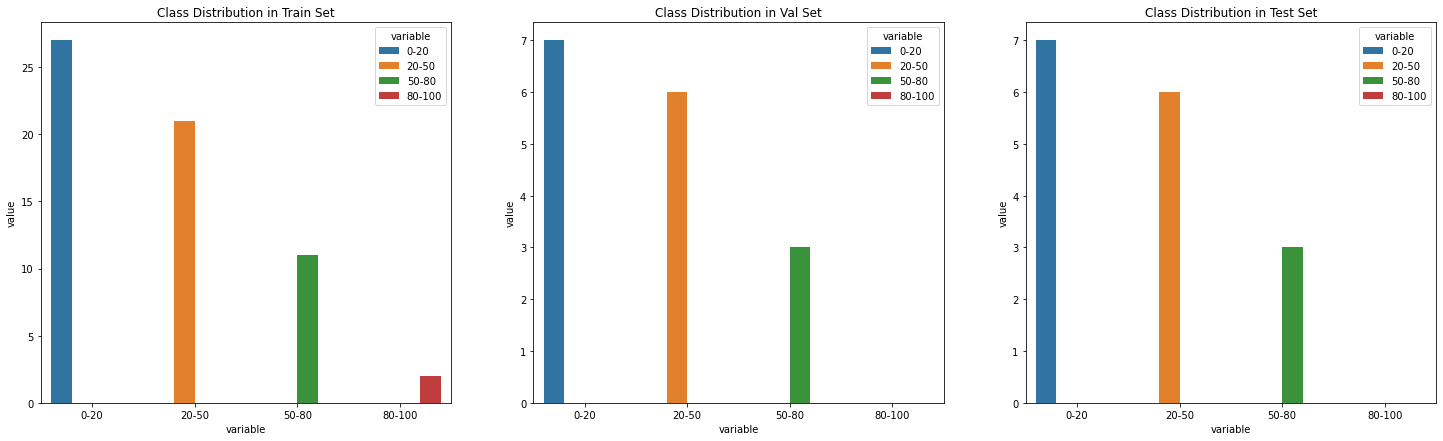

In [107]:
# spojrzenie okiem na dane i ich rozkład

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [108]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [109]:
# przygotowanie datasetów dla poszczególnych zbiorów
train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [110]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)

target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [111]:
class_count = [i for i in get_class_distribution(y_train).values()]
print('Liczba elementów w klasach: {}'.format(class_count))
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

Liczba elementów w klasach: [27, 21, 11, 2]
tensor([0.0370, 0.0476, 0.0909, 0.5000])


In [112]:
class_weights_all = class_weights[target_list]

In [113]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

#### Parametry modelu:

In [114]:
EPOCHS = 300
BATCH_SIZE = 16
LEARNING_RATE = 0.05
NUM_FEATURES = len(features.columns)
NUM_CLASSES = len(class_count)

print(f'Num features: {NUM_FEATURES} and num classes: {NUM_CLASSES}')

Num features: 2 and num classes: 4


In [115]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [116]:
model = CleaningEfficiencyModel(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)

model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(model)

CleaningEfficiencyModel(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_out): Linear(in_features=10, out_features=4, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.2, inplace=False)
  (sigmoid): Sigmoid()
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [117]:
# wyznaczanie dokładności na podstawie porównania przewidywanej z testową
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

In [118]:
# przygotowanie tablic do przechowywania dokładności i strat

accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

#### Trenowanie modelu:

In [119]:
print("Rozpoczęcie trenowania")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():   # To prevent tracking history (and using memory)
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Rozpoczęcie trenowania


Epoch 001: | Train Loss: 1.38753 | Val Loss: 1.39769 | Train Acc: 0.000| Val Acc: 18.750
Epoch 002: | Train Loss: 1.38735 | Val Loss: 1.37905 | Train Acc: 0.000| Val Acc: 18.750
Epoch 003: | Train Loss: 1.39855 | Val Loss: 1.34107 | Train Acc: 0.000| Val Acc: 18.750
Epoch 004: | Train Loss: 1.31912 | Val Loss: 1.31532 | Train Acc: 0.000| Val Acc: 43.750
Epoch 005: | Train Loss: 1.28400 | Val Loss: 1.29398 | Train Acc: 50.000| Val Acc: 43.750
Epoch 006: | Train Loss: 1.26040 | Val Loss: 1.28174 | Train Acc: 25.000| Val Acc: 62.500
Epoch 007: | Train Loss: 1.30012 | Val Loss: 1.29972 | Train Acc: 25.000| Val Acc: 18.750
Epoch 008: | Train Loss: 1.26214 | Val Loss: 1.32155 | Train Acc: 0.000| Val Acc: 18.750
Epoch 009: | Train Loss: 1.33608 | Val Loss: 1.32472 | Train Acc: 0.000| Val Acc: 18.750
Epoch 010: | Train Loss: 1.46960 | Val Loss: 1.32447 | Train Acc: 0.000| Val Acc: 18.750
Epoch 011: | Train Loss: 1.23799 | Val Loss: 1.33394 | Train Acc: 0.000| Val Acc: 18.750
Epoch 012: | Train

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

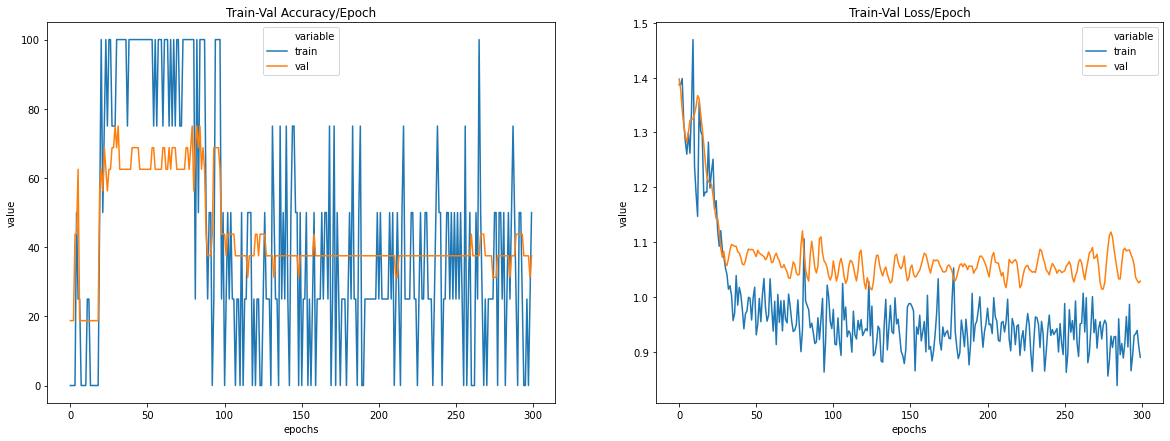

In [120]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

#### Testowanie modelu:

In [121]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [122]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.46      1.00      0.63         6
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         0

    accuracy                           0.50        16
   macro avg       0.37      0.42      0.36        16
weighted avg       0.36      0.50      0.39        16



C:\Users\cyrpa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cyrpa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- The recall means "how many of this class you find over the whole number of element of this class"

- The precision will be "how many are correctly classified among that class"

- The f1-score is the harmonic mean between precision & recall

- The support is the number of occurence of the given class in your dataset

In [123]:
print ("Actual:   ", *y_test[:20])
print ("Predicted:", *y_pred_list[:20])

Actual:    0 0 1 0 1 2 0 1 0 1 0 1 2 2 1 0
Predicted: 1 1 1 1 1 2 1 1 1 1 1 1 2 3 1 1


## Przypadek drugi
#### Skala oceny efektywności oczyszczania RE:
- mniej niż 50% jako **0**
- więcej niż 50% jako **1**

In [55]:
# zamiana wartości RE na klasy
target_classes_s = get_2_classes_from_target(target)

In [56]:
# podział na dane testowe, do treningu i walidacji

# train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(features, target_classes_s, test_size=0.17, stratify=target_classes_s, random_state=42)

#train -> train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=21)

In [57]:
# normalizacja
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [58]:
# funkcja do pozyskania rozkładu. Zbiera ilość elementów dla poszczególnych klas.

def get_class_distribution2(obj):
    count_dict = {
        "0-50": 0,
        "50-100": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['0-50'] += 1
        elif i == 1: 
            count_dict['50-100'] += 1           
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

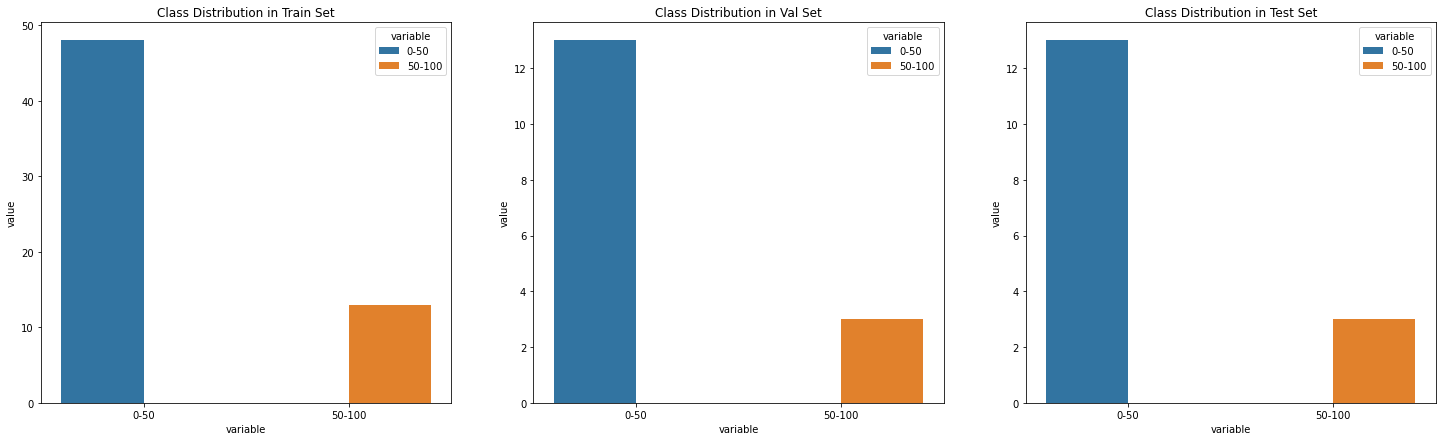

In [59]:
# spojrzenie okiem na dane i ich rozkład

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution2(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution2(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution2(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [60]:
# przygotowanie datasetów dla poszczególnych zbiorów
train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [61]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)

target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [62]:
class_count = [i for i in get_class_distribution2(y_train).values()]
print('Liczba elementów w klasach: {}'.format(class_count))
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

Liczba elementów w klasach: [48, 13]
tensor([0.0208, 0.0769])


In [63]:
class_weights_all = class_weights[target_list]
class_weights_all

tensor([0.0208, 0.0208, 0.0208, 0.0208, 0.0208, 0.0208, 0.0208, 0.0208, 0.0208,
        0.0769, 0.0208, 0.0769, 0.0208, 0.0208, 0.0208, 0.0208, 0.0769, 0.0769,
        0.0208, 0.0208, 0.0208, 0.0208, 0.0208, 0.0208, 0.0769, 0.0208, 0.0208,
        0.0208, 0.0208, 0.0208, 0.0769, 0.0208, 0.0208, 0.0769, 0.0769, 0.0208,
        0.0208, 0.0208, 0.0769, 0.0208, 0.0208, 0.0208, 0.0208, 0.0769, 0.0208,
        0.0208, 0.0208, 0.0208, 0.0769, 0.0769, 0.0208, 0.0208, 0.0208, 0.0208,
        0.0208, 0.0208, 0.0769, 0.0208, 0.0208, 0.0208, 0.0208])

In [64]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [65]:
EPOCHS = 200
BATCH_SIZE = 16
LEARNING_RATE = 0.0007
NUM_FEATURES = len(features.columns)
NUM_CLASSES = len(class_count)

print(f'Num features: {NUM_FEATURES} and num classes: {NUM_CLASSES}')

Num features: 2 and num classes: 2


In [66]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [67]:
model = CleaningEfficiencyModel(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)

model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(model)

CleaningEfficiencyModel(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_out): Linear(in_features=10, out_features=2, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [68]:
# przygotowanie tablic do przechowywania dokładności i strat

accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [69]:
print("Rozpoczęcie trenowania")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():   # To prevent tracking history (and using memory)
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Rozpoczęcie trenowania


Epoch 001: | Train Loss: 0.68207 | Val Loss: 0.67193 | Train Acc: 100.000| Val Acc: 81.250
Epoch 002: | Train Loss: 0.69343 | Val Loss: 0.67113 | Train Acc: 75.000| Val Acc: 81.250
Epoch 003: | Train Loss: 0.68871 | Val Loss: 0.67038 | Train Acc: 100.000| Val Acc: 81.250
Epoch 004: | Train Loss: 0.69032 | Val Loss: 0.66958 | Train Acc: 100.000| Val Acc: 81.250
Epoch 005: | Train Loss: 0.69178 | Val Loss: 0.66916 | Train Acc: 100.000| Val Acc: 81.250
Epoch 006: | Train Loss: 0.69572 | Val Loss: 0.66890 | Train Acc: 100.000| Val Acc: 81.250
Epoch 007: | Train Loss: 0.68371 | Val Loss: 0.66829 | Train Acc: 100.000| Val Acc: 81.250
Epoch 008: | Train Loss: 0.68033 | Val Loss: 0.66746 | Train Acc: 100.000| Val Acc: 81.250
Epoch 009: | Train Loss: 0.68958 | Val Loss: 0.66655 | Train Acc: 100.000| Val Acc: 81.250
Epoch 010: | Train Loss: 0.69375 | Val Loss: 0.66594 | Train Acc: 100.000| Val Acc: 81.250
Epoch 011: | Train Loss: 0.68082 | Val Loss: 0.66532 | Train Acc: 100.000| Val Acc: 81.250


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

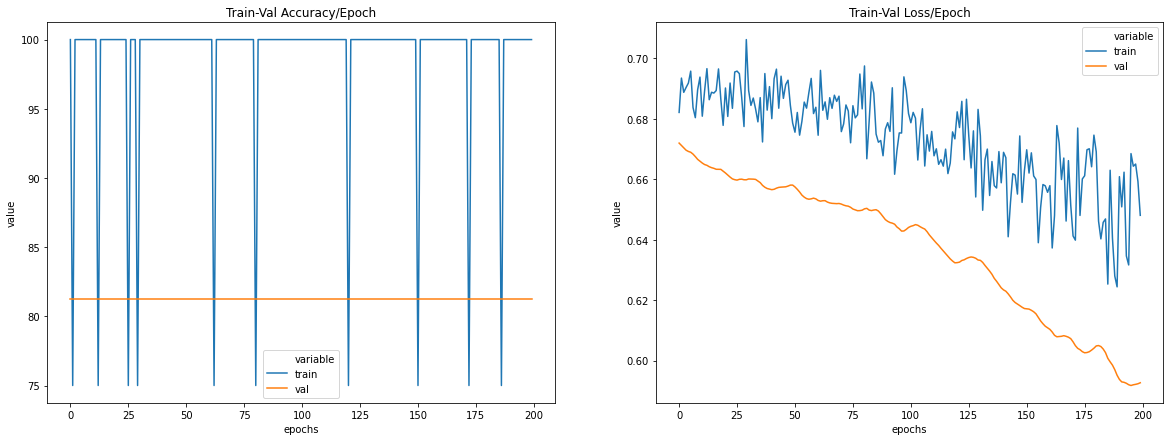

In [70]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [71]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [72]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90        13
           1       0.00      0.00      0.00         3

    accuracy                           0.81        16
   macro avg       0.41      0.50      0.45        16
weighted avg       0.66      0.81      0.73        16



C:\Users\cyrpa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
print ("Actual:   ", *y_test[:20])
print ("Predicted:", *y_pred_list[:20])

Actual:    0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0
Predicted: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
